In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import cv2

In [2]:
data_dir = 'drive/MyDrive/kaggle_mnist/digit-recognizer/'

for dirname, _, filenames in os.walk('drive/MyDrive/kaggle_mnist/digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

drive/MyDrive/kaggle_mnist/digit-recognizer/test.csv
drive/MyDrive/kaggle_mnist/digit-recognizer/sample_submission.csv
drive/MyDrive/kaggle_mnist/digit-recognizer/train.csv


In [3]:
train_data = pd.read_csv(data_dir + 'train.csv')
test_data = pd.read_csv(data_dir + 'test.csv')

In [4]:
train_images = train_data.drop('label', axis=1).values.reshape(-1, 1, 28, 28)
test_images = test_data.values.reshape(-1, 1, 28, 28)
train_labels = train_data['label'].values

# nomalization
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

print(train_images.shape)
print(test_images.shape)

(42000, 1, 28, 28)
(28000, 1, 28, 28)


In [26]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42, stratify=train_labels)
print(type(train_images[0][0][0][0]))
print(type(valid_images[0][0][0][0]))

train_tensor = torch.utils.data.TensorDataset(torch.tensor(train_images), torch.tensor(train_labels))
valid_tensor = torch.utils.data.TensorDataset(torch.tensor(valid_images), torch.tensor(valid_labels))
test_tensor = torch.utils.data.TensorDataset(torch.tensor(test_images))

train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_tensor, batch_size=64, shuffle=False)
test_loader = DataLoader(test_tensor, batch_size=100, shuffle=False)

<class 'numpy.float32'>
<class 'numpy.float32'>


In [41]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (batch, 1, 28, 28)  ->  (batch, 32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                                          # (batch, 32, 28, 28)  ->  (batch, 32, 14, 14)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (batch, 32, 14, 14)  ->  (batch, 64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                                          # (batch, 64, 14, 14)  ->  (batch, 64, 7, 7)
            nn.Flatten()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=7*7*64, out_features=64),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [42]:
model = Network()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Network(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (layer3): Sequential(
    (0): Linear(in_features=3136, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=10, bias=True)
    (2): Softmax(dim=1)
  )
)

In [43]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

In [44]:
test_pred = []

with torch.no_grad():
    for step in range(len(test_loader)):
        images = next(iter(test_loader))

        predictions = model(images[0])

        test_pred.append(softmax(predictions.detach().cpu().numpy()))

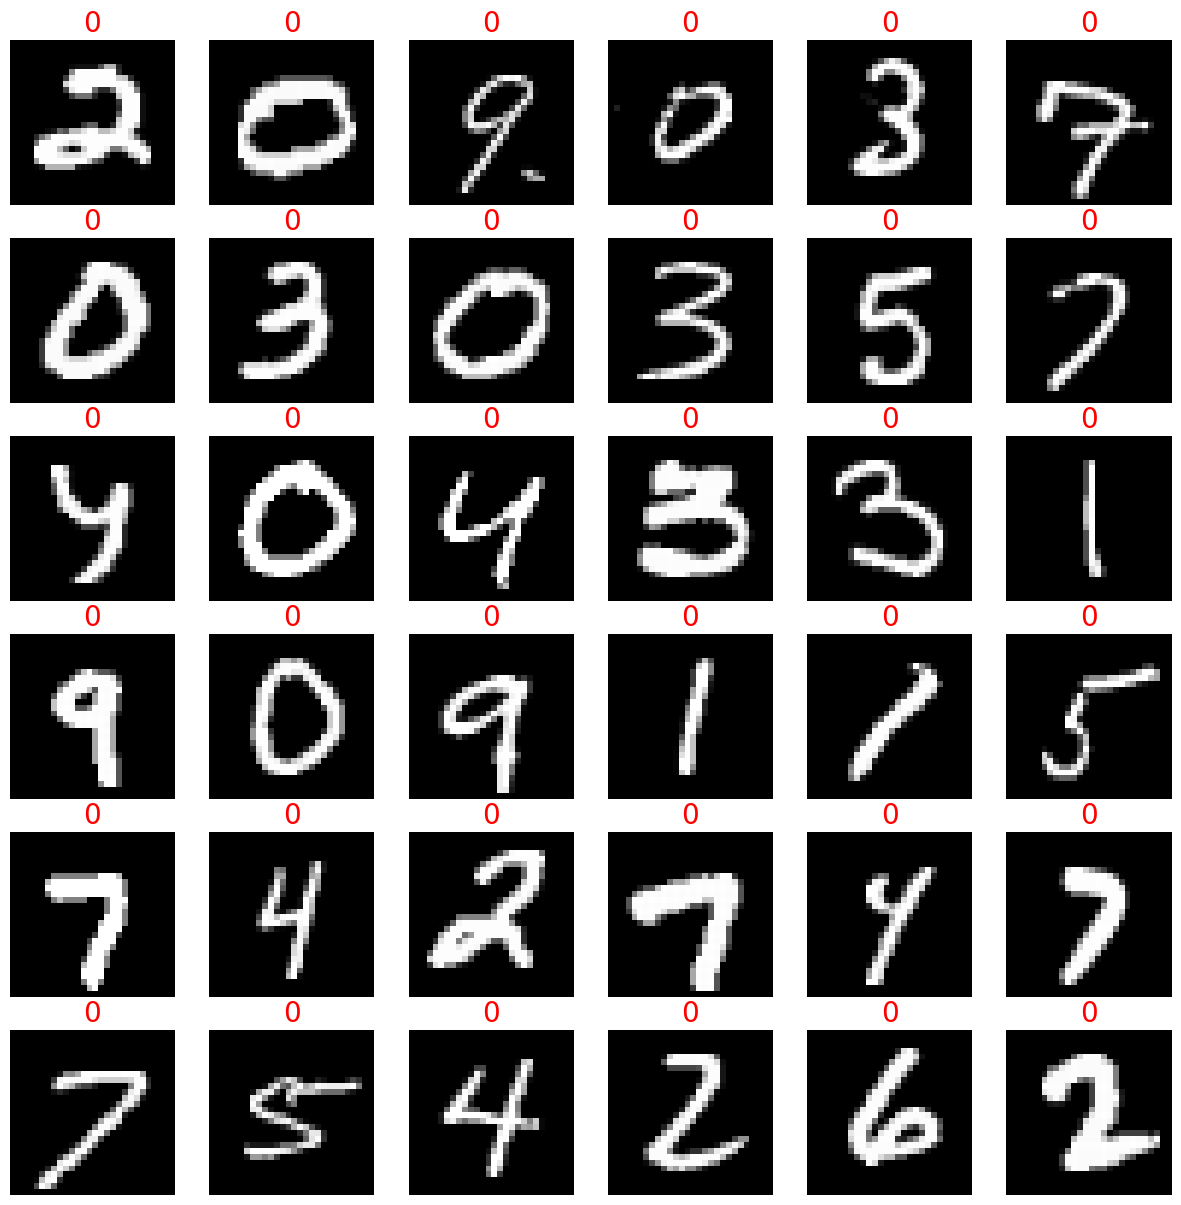

In [45]:
test_batch = next(iter(test_loader))[0]
test_X = test_batch.reshape(-1, 28, 28)[:36]
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

for i, image in enumerate(test_X):
    ax[i//6][i%6].axis('off'); ax[i//6][i%6].imshow(image, cmap='gray')
    ax[i//6][i%6].set_title(np.argmax(test_pred[0][i], axis=0), fontsize=20, color="red")

In [46]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [48]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):

    train_loss = 0
    valid_loss = 0
    running_loss = 0

    # train
    model.train()
    for step in range(1, len(train_loader) + 1):
        images, labels = next(iter(train_loader))

        predictions = model(images)
        loss = criterion(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        sys.stdout.write('\r')
        sys.stdout.write("step: %d/%d  train_loss: %.5f" % (step, len(train_loader), train_loss/step))
        sys.stdout.flush()

    train_loss = train_loss / len(train_loader)
    print()
    print("epoch: {}  train_loss: {:.5f}".format(epoch, train_loss))

    # validation
    model.eval()
    with torch.no_grad():
        for step in range(1, len(valid_loader) + 1):
            images, labels = next(iter(valid_loader))
            predictions = model(images)
            loss = criterion(predictions, labels)

            valid_loss += loss.item()
            sys.stdout.write('\r')
            sys.stdout.write("step: %d/%d  valid_loss: %.5f" % (step, len(valid_loader), valid_loss/step))
            sys.stdout.flush()

    valid_loss = valid_loss / len(train_loader)
    print()
    print("epoch: {}  valid_loss: {:.5f}".format(epoch, valid_loss))
    print()

step: 562/562  train_loss: 1.73803
epoch: 1  train_loss: 1.73803
step: 63/63  valid_loss: 1.68379
epoch: 1  valid_loss: 0.18875

step: 562/562  train_loss: 1.62392
epoch: 2  train_loss: 1.62392
step: 63/63  valid_loss: 1.64372
epoch: 2  valid_loss: 0.18426

step: 562/562  train_loss: 1.60274
epoch: 3  train_loss: 1.60274
step: 63/63  valid_loss: 1.63564
epoch: 3  valid_loss: 0.18335

step: 562/562  train_loss: 1.59082
epoch: 4  train_loss: 1.59082
step: 63/63  valid_loss: 1.61626
epoch: 4  valid_loss: 0.18118

step: 562/562  train_loss: 1.58784
epoch: 5  train_loss: 1.58784
step: 63/63  valid_loss: 1.61191
epoch: 5  valid_loss: 0.18069

step: 562/562  train_loss: 1.58117
epoch: 6  train_loss: 1.58117
step: 63/63  valid_loss: 1.61025
epoch: 6  valid_loss: 0.18051

step: 562/562  train_loss: 1.58207
epoch: 7  train_loss: 1.58207
step: 63/63  valid_loss: 1.60628
epoch: 7  valid_loss: 0.18006

step: 562/562  train_loss: 1.57725
epoch: 8  train_loss: 1.57725
step: 63/63  valid_loss: 1.60298

In [49]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

In [50]:
test_pred = []
# softmax = nn.Softmax(dim=1)
with torch.no_grad():
    for step in range(len(test_loader)):
        images = next(iter(test_loader))

        predictions = model(images[0])

        test_pred.append(softmax(predictions.detach().cpu().numpy()))

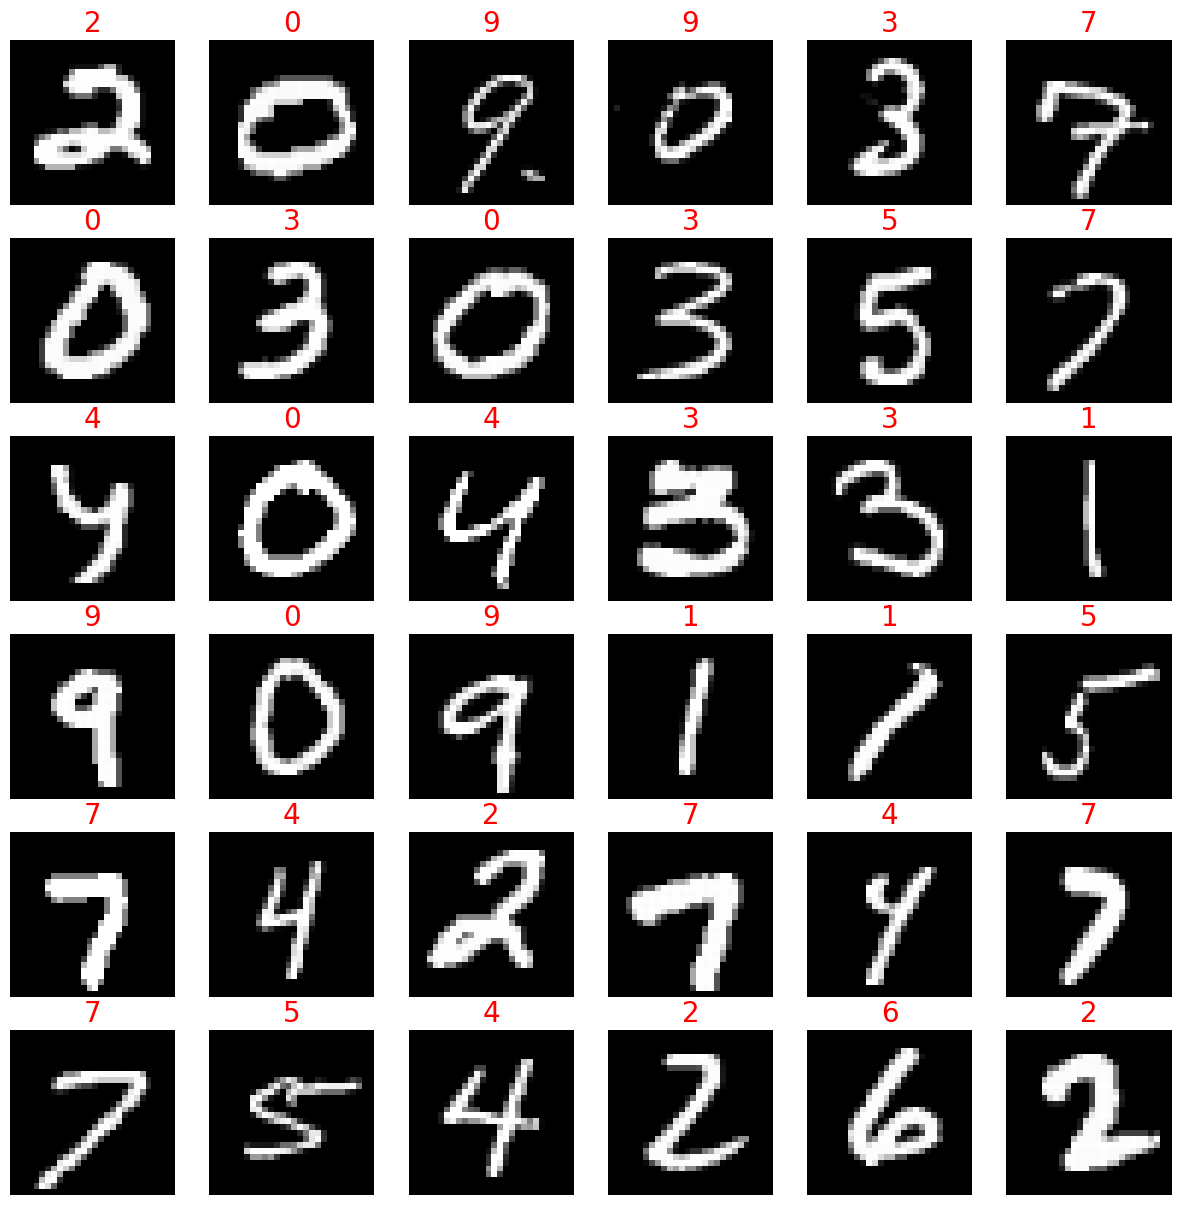

In [51]:
test_batch = next(iter(test_loader))[0]
test_X = test_batch.reshape(-1, 28, 28)[:36]
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

for i, image in enumerate(test_X):
    ax[i//6][i%6].axis('off'); ax[i//6][i%6].imshow(image, cmap='gray')
    ax[i//6][i%6].set_title(np.argmax(test_pred[0][i], axis=0), fontsize=20, color="red")

In [56]:
submission = pd.read_csv(data_dir + 'sample_submission.csv')
print(np.concatenate(test_pred, axis=0).shape)
submission["Label"] = np.argmax(np.concatenate(test_pred, axis=0), axis=1)

(28000, 10)


In [57]:
submission.head(15)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
